# Analiza zbioru danych dotyczącego cen smartfonów

Projekt ten ma na celu przeprowadzenie analizy eksploracyjnej oraz wykonanie regresji liniowej na zbiorze danych dotyczących smartfonów.

Link do zbioru: https://www.kaggle.com/datasets/swahajraza/a-dataset-of-smartphone-specifications-and-prices

# Analiza zbioru

## Import bibliotek

In [280]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

## Wczytanie zbioru

In [281]:
df = pd.read_csv('smartphone_specifications_and_prices.csv')

df

,brand_name,model,display,front_camera,rare_camera,processor,battery_capacity,ram,internal_storage,price
0,SAMSUNG,Samsung S24 Ultra,"6.8"" (120Hz)",40MP,108MP + 10MP + 10MP + 12MP,Exynos,5000 mAh,8.0,128,334999.0
1,SAMSUNG,Samsung S24 Plus,"6.6"" (120Hz)",10MP,50MP + 10MP + 12MP,Exynos,4500 mAh,8.0,128,189999.0
2,SAMSUNG,Samsung Zero,"6.41"" (120Hz)",32 MP,12 MP + 8 MP + 12 MP,Snapdragon 888 5G,4500 mAh,8.0,256,112999.0
3,SAMSUNG,Samsung S24,"6.1"" (120Hz)",10MP,50MP + 10MP + 12MP,Exynos,3700 mAh,8.0,128,249999.0
4,SAMSUNG,Samsung A05s,"6.5"" (90Hz)",5MP,50MP + 2MP + 2MP,Exynos,5000 mAh,4.0,64,24999.0
...,...,...,...,...,...,...,...,...,...,...
1251,OPPO,Oppo A37,"5.0""",5 MP,8 MP,Snapdragon 410,2630mAh,2.0,16,88415.0
1252,OPPO,Oppo F1,"5.0""",8 MP,13 MP,Snapdragon 616,-,3.0,16,35999.0
1253,OPPO,Oppo A31,"4.5""",5 MP,8 MP,Snapdragon 410,2000mAh,1.0,8,88415.0
1254,OPPO,Oppo Reno 4 SE,"6.43""",32 MP,48 MP + 8 MP + 2 MP,Dimensity 720,4300mAh,8.0,128,88415.0


## Dodanie atrybutu 'score' poprzez połączenie ze zbiorem danych

Atrybut *score* opsiuje ogólną ocenę procesora, ze strony https://nanoreview.net/en/soc-list/rating

In [282]:
dd = pd.read_csv('../web-scraping/extra_data.csv')

pd.merge(df, dd, on = 'processor')

,brand_name,model,display,front_camera,rare_camera,processor,battery_capacity,ram,internal_storage,price,score
0,SAMSUNG,Samsung A54,"6.5"" (90Hz)",32 MP,64 MP + 12 MP + 1125 MP + 5 MP,Snapdragon 720G,4500 mAh,8.0,128,59999.0,38
1,SAMSUNG,Samsung A54 256GB,"6.5"" (90Hz)",32 MP,64 MP + 12 MP + 1125 MP + 5 MP,Snapdragon 720G,4500 mAh,8.0,256,65999.0,38
2,SAMSUNG,Samsung A73,"6.7"" (90Hz)",32 MP,108MP + 8MP + 2MP + 2MP,Snapdragon 720G,5000 mAh,8.0,128,67999.0,38
3,XIAOMI,Poco M2 Pro,"6.67""",16 MP,48 MP + 8 MP + 5 MP + 2 MP,Snapdragon 720G,5000mAh,4.0,64,31999.0,38
4,XIAOMI,Poco M2 Pro 6GB Ram,"6.67""",16 MP,48 MP + 8 MP + 5 MP + 2 MP,Snapdragon 720G,5000mAh,6.0,128,37999.0,38
...,...,...,...,...,...,...,...,...,...,...,...
206,OPPO,Oppo A5 2020,"6.5""",8 MP,12 MP + 8 MP + 2 MP + 2 MP,Snapdragon 665,5000mAh,3.0,64,27999.0,28
207,OPPO,Oppo A5 2020 4GB Ram,"6.5""",8 MP,12 MP + 8 MP + 2 MP + 2 MP,Snapdragon 665,5000mAh,4.0,64,31999.0,28
208,OPPO,Oppo A9 2020,"6.5""",16 MP,48 MP + 8 MP + 2 MP + 2 MP,Snapdragon 665,5000mAh,8.0,128,37999.0,28
209,OPPO,Oppo Reno 4 SE,"6.43""",32 MP,48 MP + 8 MP + 2 MP,Dimensity 720,4300mAh,8.0,128,88415.0,37


Jak można zauważyć, usunęło to bardzo dużą ilość danych. Głównie przez braki w tych danych lub kompatybilność zbioru danych z pliku extra_data.csv z rozważanym zbiorem.

## Poprawienie kompatybilności danych

In [283]:
def get_rid_of_5G(s):
    '''
    funkcja usuwa z ciągu znaków znaki ' 5G'
    '''
    if '5G' in s:
        if '+ 5G' in s:
            return s.replace('+ 5G', '')
        else: 
            return s.replace(' 5G', '')
    return s

df['processor'] = df['processor'].astype(str)
# print(df.dtypes)
df['processor'] = df['processor'].apply(get_rid_of_5G)

Naprawienie problemu z nazwą 'Apple Bionic Ax' , gdzie x > 11, ponieważ w nazwach procesora występują nazwy 'Bionic Ax'.

In [284]:
def get_rid_of_Apple_in_processor_name(s):
    words = s.split(' ')
    if len(words) > 2 & ('Apple' in words):
        return s.replace('Apple ', '')
    else:
        return s
    
df['processor'] = df['processor'].apply(get_rid_of_Apple_in_processor_name)

Zamiana znaku '+' na 'Plus' - ze względu na sposób zapisu w zbiorze ze statystykimi procesorów

In [285]:
def get_rid_of_plus_sign(s):
    return s.replace('+', ' Plus')

df['processor'] = df['processor'].apply(get_rid_of_plus_sign)

Usunięcie powtarzających się 2 razy nazwy producenta procesora MediaTek

In [286]:
def replace_Mediatek_with_helio(s):
    if 'MediaTek' in s:
        if ('P' in s or 'G' in s) and not 'Helio' in s:
            return s.replace('MediaTek', 'Helio')
        return s.replace('MediaTek', '')
    if 'Mediatek' in s:
        if ('P' in s or 'G' in s) and not 'Helio' in s:
            return s.replace('Mediatek', 'Helio')
        return s.replace('Mediatek', '')
    return s

df['processor'] = df['processor'].apply(replace_Mediatek_with_helio)

In [287]:
def replace_Gen1_with_Gen_1(s):
    return s.replace('Gen1', 'Gen 1')

df['processor'] = df['processor'].apply(replace_Gen1_with_Gen_1)

In [288]:
def return_for_iPhone_12(s):
    if s == 'A14':
        return 'A14 Bionic'
    return s

df['processor'] = df['processor'].apply(return_for_iPhone_12)

Ustawienie procesorów dla konkretnych telefonów

In [289]:
def set_processor_for_iPhones(row):
    if 'iPhone 15 Pro' in row['model']:
        return 'A17 Pro'
    elif 'iPhone 15' in row['model']:
        return 'A16 Bionic'
    elif 'iPhone 6s' in row['model']:
        return 'Apple A9'
    return row['processor']

df['processor'] = df.apply(set_processor_for_iPhones, axis = 1)

Usunięcie wyrazu, który zaczyna się na MT

In [290]:
df['processor'] = df['processor'].replace(r'\bMT\w*\b', '', regex = True)

In [291]:
def get_rid_of_last_first_space(s):
    return s.strip();

df['processor'] = df['processor'].apply(get_rid_of_last_first_space)

In [292]:
def get_rid_of_octa(s):
    if 'Octa' in s:
        return s.replace(' Octa', '')
    return s

df['processor'] = df['processor'].apply(get_rid_of_octa)

In [293]:
def add_G_to_snapdragon_750(s):
    if s == 'Snapdragon 750':
        return s+'G'
    return s

df['processor'] = df['processor'].apply(add_G_to_snapdragon_750)

Sprawdzenie jakie rezultaty daje teraz scalanie

In [294]:
df = pd.merge(df, dd, how = 'left', on = 'processor')
#print(dg[dg['brand_name'] == 'APPLE'])
print("Obiektów przed scaleniem: ", len(df))

df = df.dropna(how = "any")
print("Obiektów po scaleniu: ", len(df))


Obiektów przed scaleniem:  1256
Obiektów po scaleniu:  968


In [295]:
#df = df[pd.isna(df['score'])][['brand_name', 'model', 'processor']]
#print(df)

df.to_csv('good_data.csv', index = False)

## Oczyszczanie danych

Zamiana atrybutu opisowego *rear_camera* na atrybuty ilościowe. Rozdzielenie atrybututu *rear_camera* na *main_camera* - główny obiektyw, *sum_MP* - sumę megapikseli matryc, i *num_cameras* - liczbę obiektywów.

In [296]:
def count_integers(s):
    '''
    funkcja zwraca ilość wystąpień cyfr <= 200
    w ciągu oraz ich sumę liczb <= 200
    '''
    # rozdziel ciąg znaków na liczby
    words = re.findall(r'\d+', s)
    # znajdź błędy w danych (> 200 MP)
    i = 0
    sum = 0
    for w in words:
        if int(w) > 200:                # ze względu na błędy w danych
            i = i - 1
        else:
            sum = sum + int(w)
    # zlicz słowa, które są liczbami
    ret = len(words) + i
    return pd.Series([ret, sum])

Warunek, na cyfry wartość <=200 wynika z błędów danych, gdzie niektóre z kamer zostały źle przepisane

In [297]:
df[['num_cameras', 'sum_MP']] = df['rare_camera'].apply(count_integers)

Dodanie atrybutów *front_camera* - ilość megapikseli w kamerze w ekranie i *main_camera* - ilość megapikseli w głownej tylnej kamerze. W danych są one podawane jako pierwsze, w przypadku kamera z przodu najczęściej występuje jedna.

In [298]:
def find_first_number(s):
    ''' 
    funkcja zwraca pierwszą napotkaną liczbę
    w ciągu znaków
    '''
    words = re.findall(r'\d+', s)
    if len(words) > 0:
        return words[0]
    else:
        return 0

In [299]:
df['front_camera'] = df['front_camera'].apply(find_first_number)
df['main_camera']  = df['rare_camera'].apply(find_first_number)

df[['front_camera', 'main_camera']] = df[['front_camera', 'main_camera']].apply(pd.to_numeric)

# nie potrzebny już atrybut
df = df.drop(columns = 'rare_camera')

Usunięcie tabletów ze zbioru danych:

In [300]:
df = df[~df['model'].str.contains('Pad|Tab', na=False)]

Usunięcie kolumn, które nie posiadały żadnych zgodnych liczb

In [301]:
df = df[df.front_camera != 0]
df = df[df.sum_MP != 0]
df = df[df.main_camera != 0]

Obrobienie wartości pojemności baterii - tylko te rekordy, które zawierają 4 cyfrową liczbę. Jest tak, ponieważ pojemności baterii zwyczajowo dla smartfonów podaje się w tysiącach mAh, pozostałe wartości, albo są nie podane, albo są podane w Wh i dotyczą tabletów

In [302]:
df = df[(df['battery_capacity'].str.contains(pat = '\d\d\d\d', regex= True))]

df['battery_capacity'] = pd.to_numeric(df['battery_capacity'].str[-8:-3])

print("Liczba obiektów:", df.shape[0])

Liczba obiektów: 948


<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\User\AppData\Local\Temp\ipykernel_13620\4251574446.py:1: SyntaxWarning: invalid escape sequence '\d'
  df = df[(df['battery_capacity'].str.contains(pat = '\d\d\d\d', regex= True))]


Rozdzielenie atrybutu 'display' na rozmiar ekranu i jego częstotliwość odświeżania. Jeżeli częstotliwość nie została podana przyjmuje się wartość 60.

In [303]:
# atrybut 'display' ma wartości podane w formie: <liczba>" <ew. odświeżanie ekranu>
df[['screen_size', 'refresh_rate']] = pd.DataFrame(df['display'].str.split('"').tolist(), index = df.index)
df = df.drop(columns = 'display')

df['refresh_rate'] = df['refresh_rate'].apply(lambda x: '60' if x == ''  else x[2:-3])

Dodanie kolumny z oceną procesora pozbyło się co najmiej kilkadziesiąt rekordów, lecz pomogło to w pewien sposób ujednolicić zbiór do aktualnych specyfikacji smartfonów poprzez wyeliminowanie tych, które są za stare.

## Podstawowe statystyki danych

In [304]:
print("Liczba obiektów:", df.shape[0])
marki = df['brand_name'].unique()
print("Liczba marek:", marki.shape[0])
for i in list(marki):
    print("Obiektów marki", i, ": ", len(df[df['brand_name'] == i]))
print("Liczba atrybutów:", df.shape[1])
print("Ilość braków:", df.isnull().sum().sum())

Liczba obiektów: 948
Liczba marek: 5
Obiektów marki SAMSUNG :  254
Obiektów marki XIAOMI :  353
Obiektów marki APPLE :  93
Obiektów marki ONEPLUS :  71
Obiektów marki OPPO :  177
Liczba atrybutów: 14
Ilość braków: 0


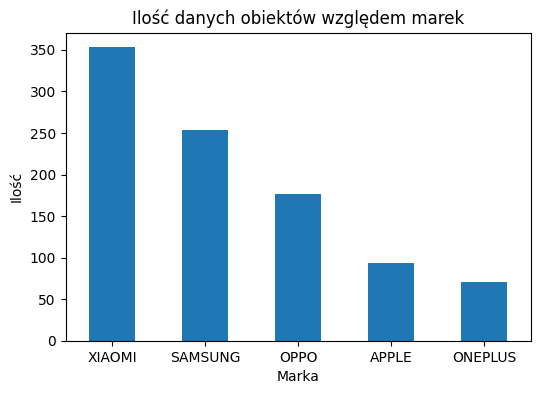

In [305]:
plt.figure(figsize=(6, 4))
df['brand_name'].value_counts().sort_values(ascending = 0).plot(kind='bar', rot = 0)
plt.title('Ilość danych obiektów względem marek', fontsize = 12)
plt.xlabel('Marka', fontsize=10)
plt.ylabel('Ilość', fontsize=10)
plt.show()

Zbiór posiada 5 producentów smartfonów oraz nie posiada braków. Większość obiektów (smartfonów) jest marki XIAOMI. Jednocześnie każdy smartfon posiada 11 atrybutów ilościowych: 
* pamięć wewnętrzną - *internal_storage* 
* pamięć RAM - *ram*
* wielkość przekątnej ekranu - *screen_size*
* odświeżanie ekranu - *refresh_rate**
* pojemność baterii - *battery* 
* cenę - *price*
* punktację procesora (od 11 do 100) - *score*
* liczba obiektów (znajdujących się z tyłu) - *num_cameras*
* suma megapikseli kamer (znajdujących się z tyłu) - *sum_MP*
* liczba megapikseli kamery frontowej - *front_camera*
* liczba megapikseli kamery z tyłu - *main_camera*

*odświeżanie ekranu może być potraktowane jako atrybut kategoryczny porządkowy, ponieważ wartości odświeżania ekranu zwykle przyjmują wartości 60, 90, 120 Hz

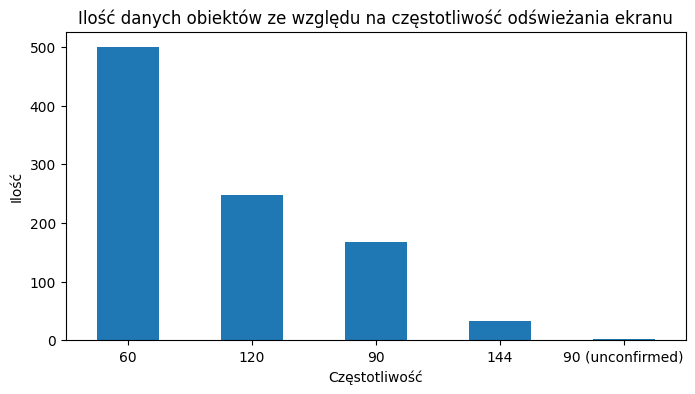

In [306]:
plt.figure(figsize=(8, 4))
df['refresh_rate'].value_counts().sort_values(ascending = 0).plot(kind='bar', rot = 0)
plt.title('Ilość danych obiektów ze względu na częstotliwość odświeżania ekranu', fontsize = 12)
plt.xlabel('Częstotliwość', fontsize=10)
plt.ylabel('Ilość', fontsize=10)
plt.show()

Pozbycie się informacji '(unconfirmed)'

In [307]:
df['refresh_rate'] = df['refresh_rate'].apply(lambda x: x[:2] if '(' in x  else x)

df[['screen_size', 'refresh_rate']] = df[['screen_size', 'refresh_rate']].apply(pd.to_numeric)

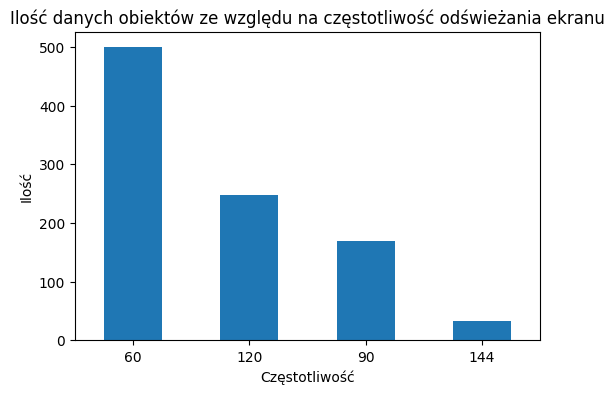

In [308]:
plt.figure(figsize=(6, 4))
df['refresh_rate'].value_counts().sort_values(ascending=0).plot(kind='bar', rot = 0)
plt.title('Ilość danych obiektów ze względu na częstotliwość odświeżania ekranu', fontsize = 12)
plt.xlabel('Częstotliwość', fontsize=10)
plt.ylabel('Ilość', fontsize=10)
plt.show()

## Wykresy pudełkowe i skrzypcowe dla danych

In [309]:
# zresetowanie indeksów
df = df.reset_index()
df = df.drop(columns = ['index'])     # usunięcie starego indeksowania

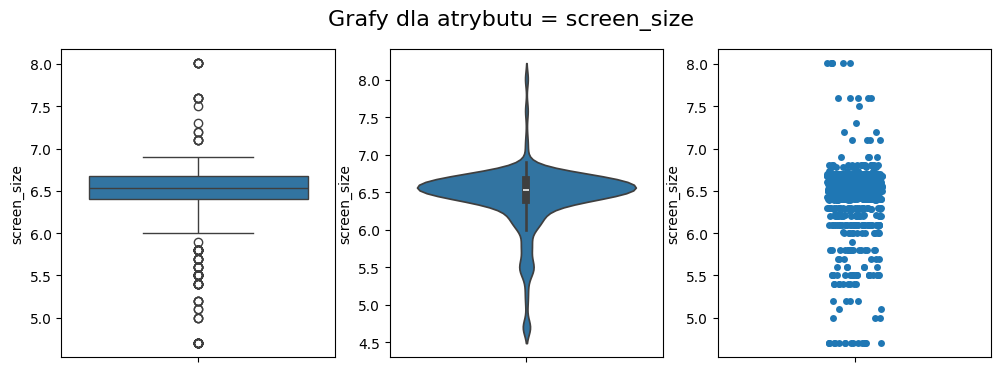

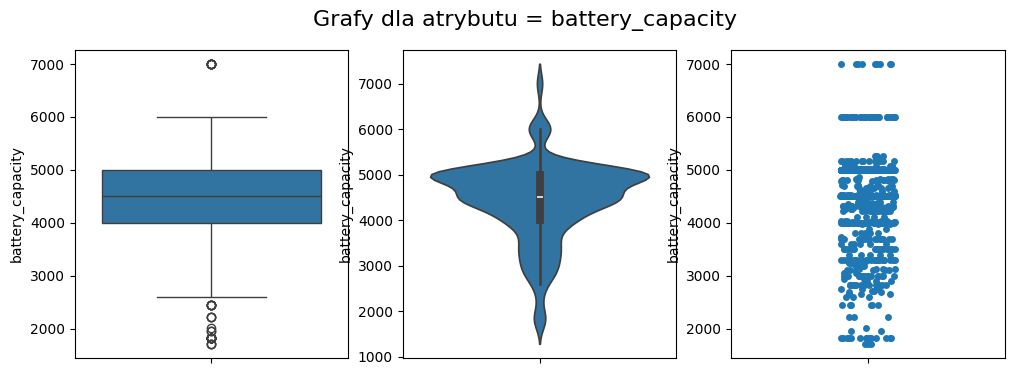

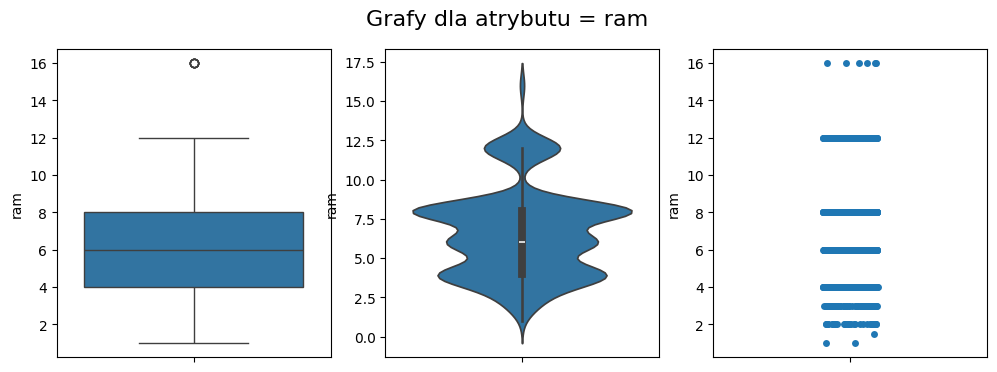

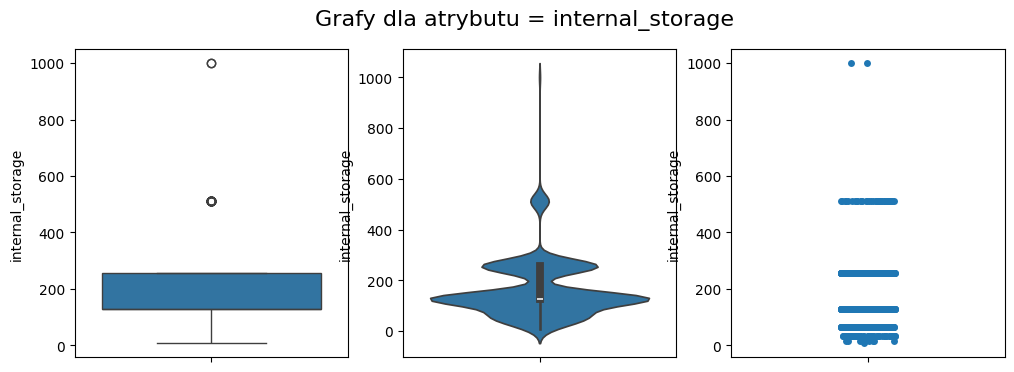

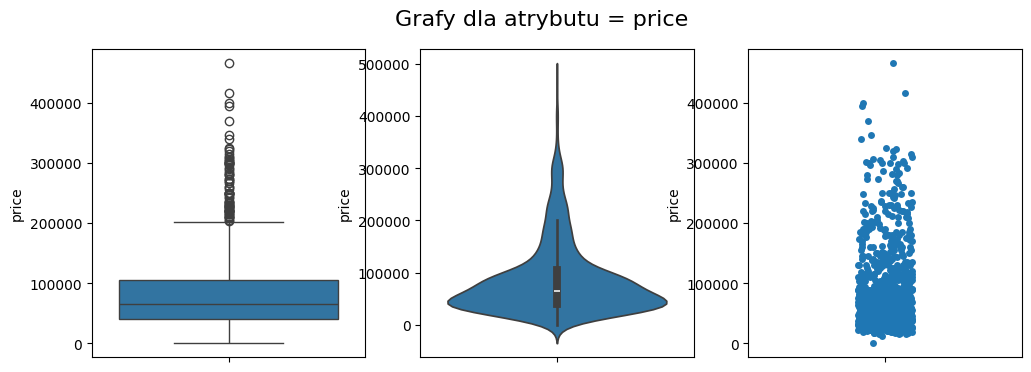

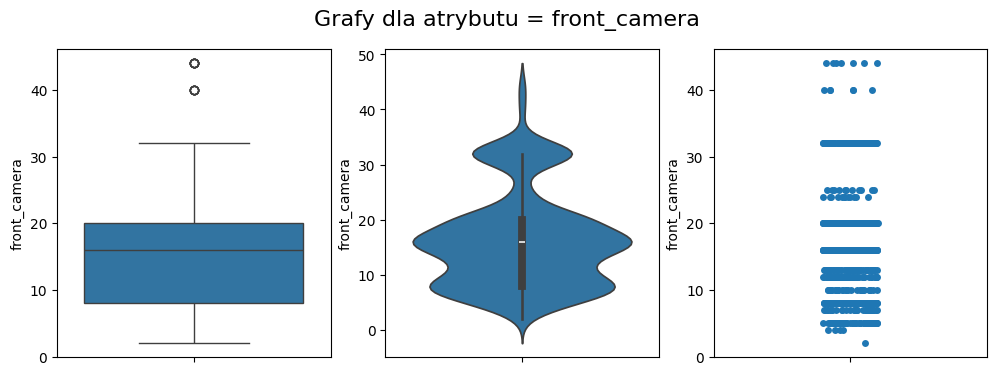

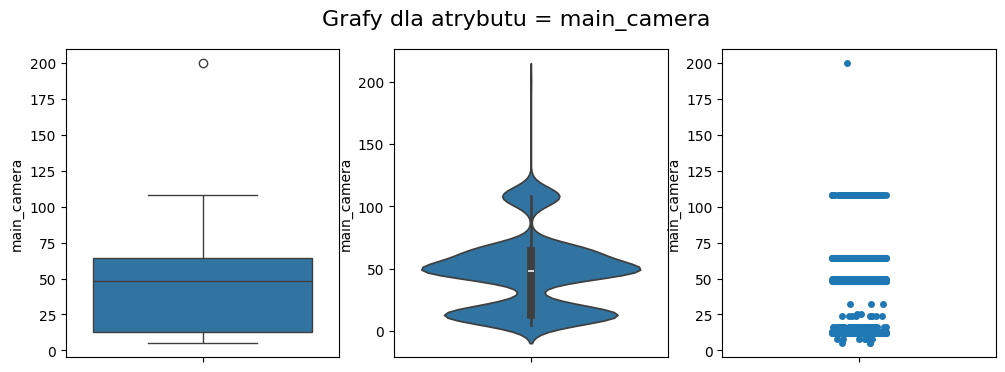

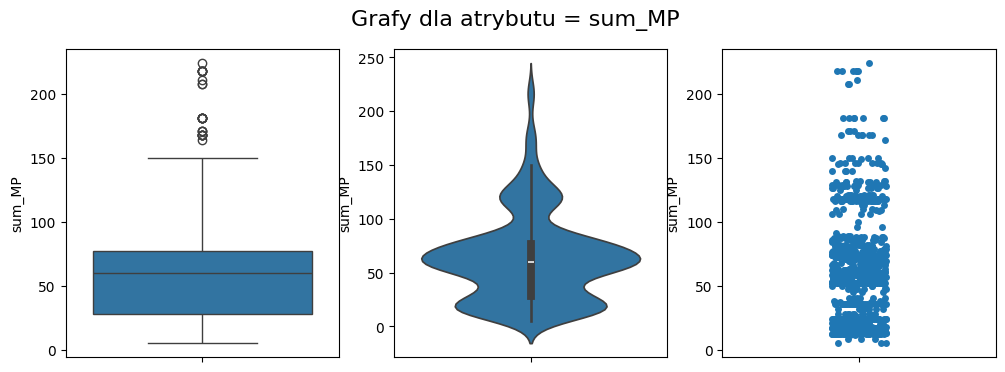

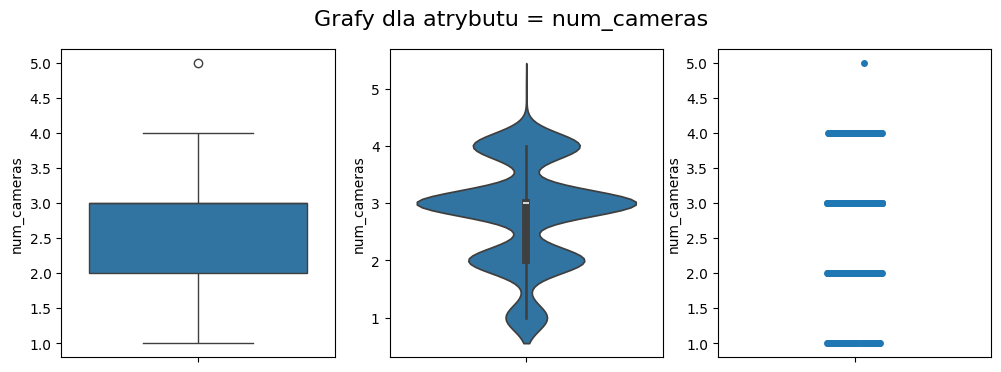

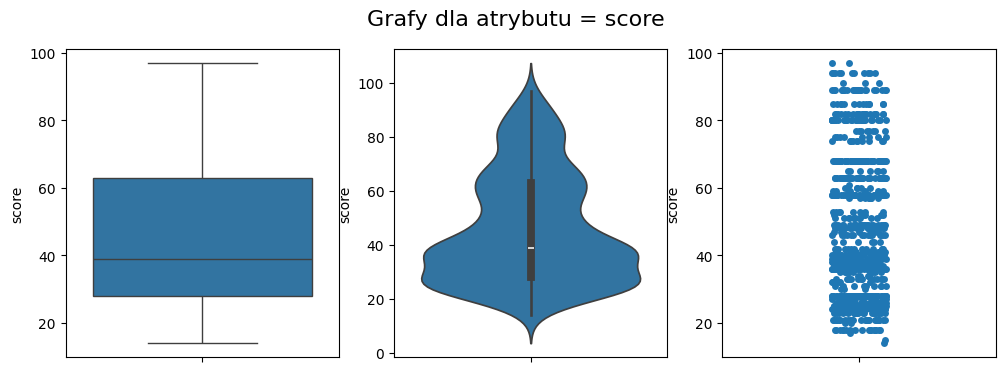

In [310]:
for attr in ['screen_size', 'battery_capacity', 'ram', 'internal_storage', 'price', 'front_camera', 'main_camera', 'sum_MP', 'num_cameras', 'score']:
    dane = df[attr]

    plt.figure(figsize=(12, 4))
    plt.suptitle(f'Grafy dla atrybutu = {attr}', fontsize=16)
    
    plt.subplot(1, 3, 1)
    plt.xticks(ha='right')
    sns.boxplot(data=dane)
    
    plt.subplot(1, 3, 2)
    plt.xticks(ha='right')
    sns.violinplot(data=dane)
    
    plt.subplot(1, 3, 3)
    plt.xticks(ha='right')
    sns.stripplot(data=dane)
    
    plt.show()

## Standardowe miary

In [311]:
description = df.describe()
description

,front_camera,battery_capacity,ram,internal_storage,price,score,num_cameras,sum_MP,main_camera,screen_size,refresh_rate
count,948.000000,948.000000,948.000000,948.000000,948.000000,948.000000,948.000000,948.000000,948.000000,948.000000,948.000000
mean,16.319620,4445.097046,6.627110,159.687764,87315.360759,46.099156,2.812236,63.572785,46.124473,6.439873,83.816456
std,8.669708,857.183287,2.798105,109.975228,69596.772928,20.324004,0.878331,40.507915,29.103923,0.415867,27.752186
min,2.000000,1715.000000,1.000000,8.000000,399.000000,14.000000,1.000000,5.000000,5.000000,4.700000,60.000000
25%,8.000000,4000.000000,4.000000,128.000000,39999.000000,28.000000,2.000000,28.000000,13.000000,6.400000,60.000000
50%,16.000000,4500.000000,6.000000,128.000000,64999.000000,39.000000,3.000000,60.000000,48.000000,6.530000,60.000000
75%,20.000000,5000.000000,8.000000,256.000000,104999.000000,63.000000,3.000000,77.000000,64.000000,6.670000,120.000000
max,44.000000,7000.000000,16.000000,1000.000000,465999.000000,97.000000,5.000000,224.000000,200.000000,8.010000,144.000000


Zmienność atrybutów

In [312]:
def calculate_coefficient_variation(column):
    return column['std']/column['mean']

description.apply(calculate_coefficient_variation, axis = 0)

front_camera        0.531244
battery_capacity    0.192838
ram                 0.422221
internal_storage    0.688689
price               0.797074
score               0.440876
num_cameras         0.312325
sum_MP              0.637190
main_camera         0.630987
screen_size         0.064577
refresh_rate        0.331107
dtype: float64

## Macierz wykresów atrybutów danych

In [313]:
#sns.pairplot(data = df, hue = 'brand_name')

Z powyższej macierzy można zauważyć, że marka APPLE charakteryzuje się mniejszymi pojemnościami baterii i trochę wyższą ceną niż pozostałe marki. Najprawdopodobniej jest to związane z użyciem przez nich własnego systemu operacyjnego, co może wskazywać na użycie osobnego modelu dla właśnie tych smartfonów. Również wśród produktów marki APPLE znajduje się najwięcje smartfonów o mniejszych rozmiarach ekranu.

## Macierz korelacji danych

<Axes: >

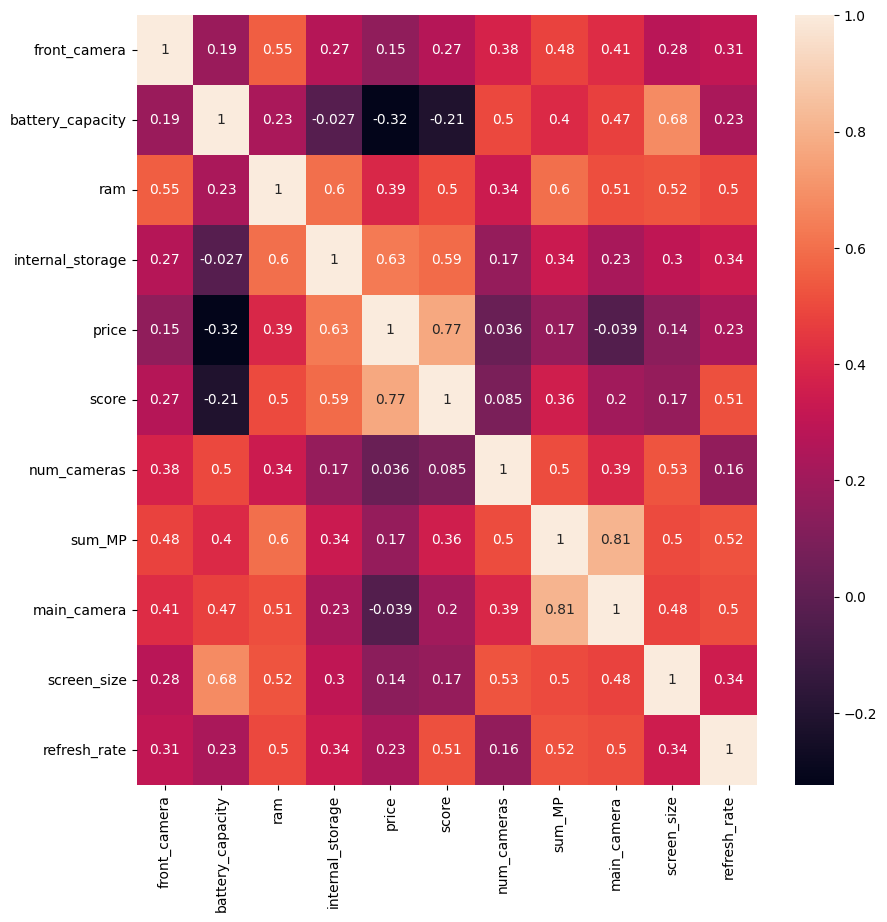

In [314]:
plt.figure(figsize=(10,10),dpi = 100)
sns.heatmap(df.iloc[:, [2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]].corr(),annot = df.iloc[:, [2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]].corr())

Największy wpływ na cenę ma punktacja na podstawie procesora, jest to mocna korelacja o wartości 0,78. Również dosyć dobrze skorelowane jest atrybut pamięci wewnętrznej, o wartości 0,6. Pozostałe atrybuty nie mają albo żadnego wpływu (korelacja bliska 0), lub bardzo mały wpływ. 
Poza tym najbradziej skorelowanymi ze sobą atrybutami są suma megapikseli i wartość megapikseli dla głównej kamery, ponieważ ta druga wartość stanowi składową pierwszej. Rozmiar ekranu i pojemność baterii również są mocno skorelowane, co jest związane z fizycznym rozmiarem urządzenia. Również ciekawym jest to, że cena i pojemność baterii jest ze sobą ujemnie skorelowana, jest to najprawdopodobniej powiązane z użyciem produktów Apple, które mają mniejszą pojemność baterii, a są widocznie droższe niż większość smartfonów z androidem.
Atrybut, który ma najmniejsza korelację są main_camera i num_cameras, są one bliskie 0. Pozostałymi atrybutami, których korelacja z ceną < 20, są: front_camera, sum_mp, screen_size.

W tym przypadku atrybutami, które jako jedyne mają wpływ są: *score*, *internal_storage*, oraz słaby wpływ: *ram*, *battery_capacity*

Z powodu na słabą korelację atrybutów między sobą i sugerowany wpływ różnic ze względu na smartfony firmy APPLE, myślę, że najlepszym sposobem do uzyskania dobrych rezultatów jest przeprowadzenie analizy jeszcze raz dla podziału na smartfony APPLE i resztę, czyli te z systemem Android

In [315]:
df_apple = df[df['brand_name'] == 'APPLE']
print('Ilość smartfonów z systemem iOS:     ', len(df_apple))
# zresetowanie indeksów
df_apple = df_apple.reset_index()
df_apple = df_apple.drop(columns = ['index'])


df_android = df[df['brand_name'] != 'APPLE']
print('Ilość smartfonów z systemem Android:', len(df_android))
# zresetowanie indeksów
df_android = df_android.reset_index()
df_android = df_android.drop(columns = ['index'])

Ilość smartfonów z systemem iOS:      93
Ilość smartfonów z systemem Android: 855


Po podziale zbiór smartfonów z iOS, jest około 9 razy mniejszy niż ten ze zbioru android.

Analiza dla smartfonów Android

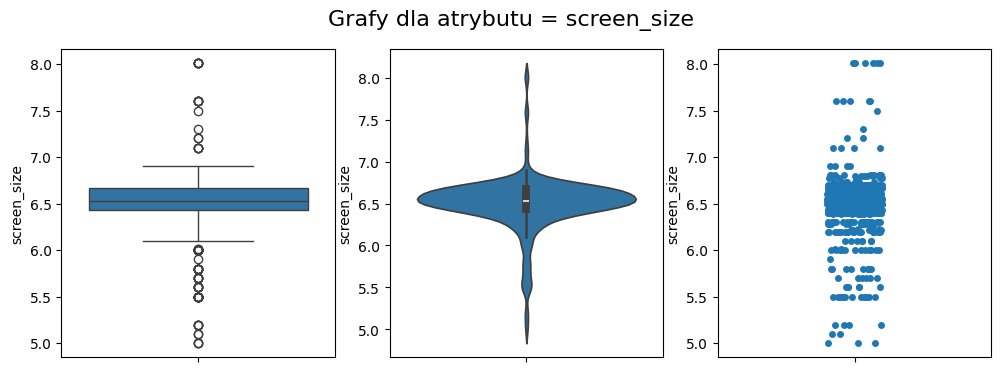

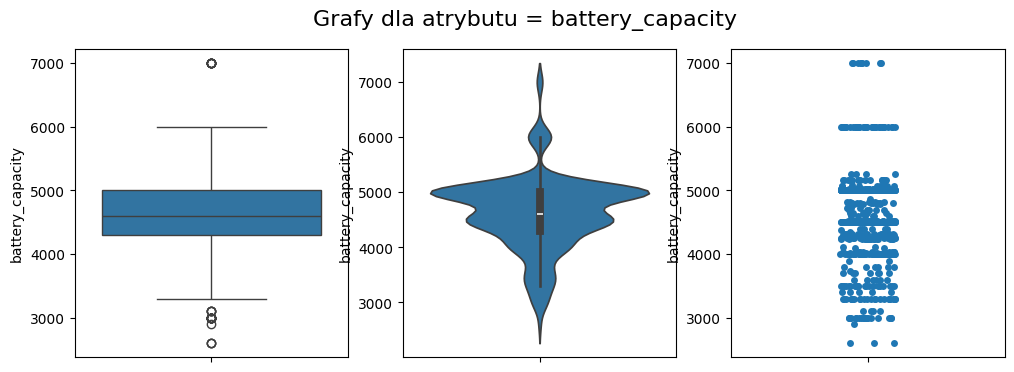

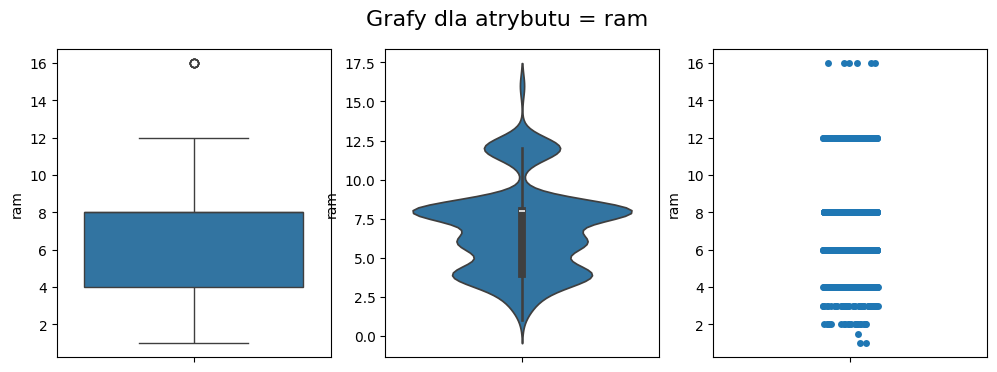

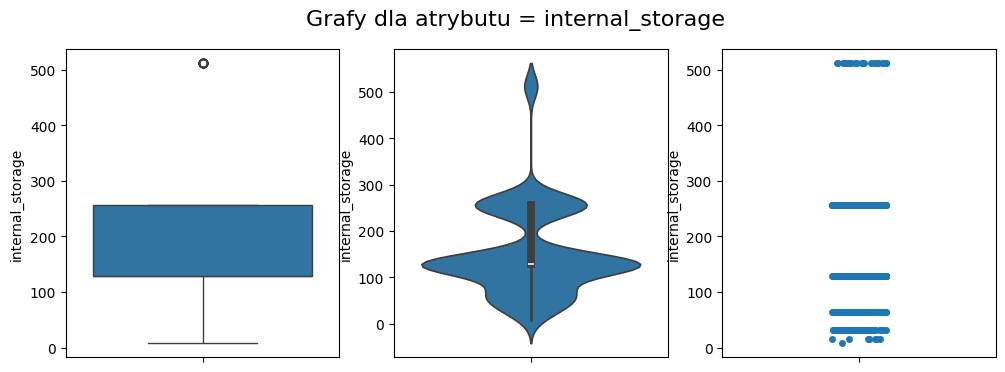

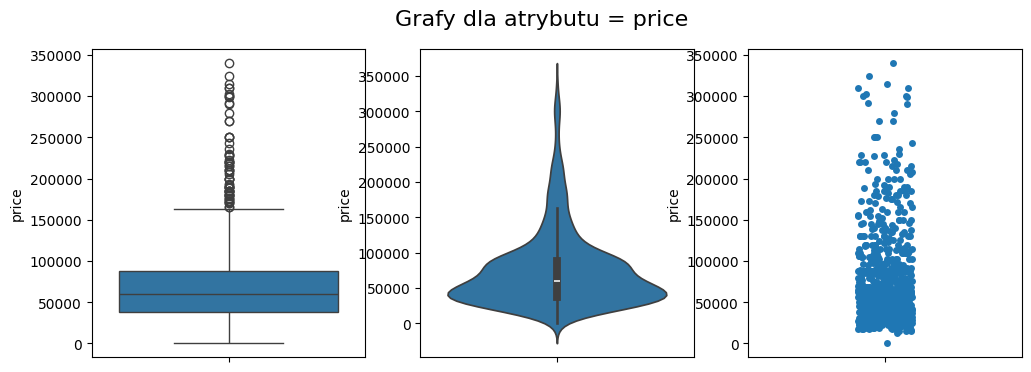

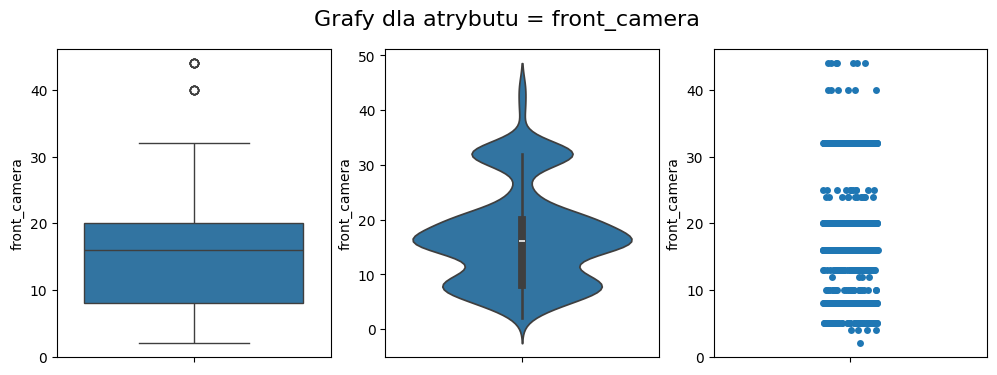

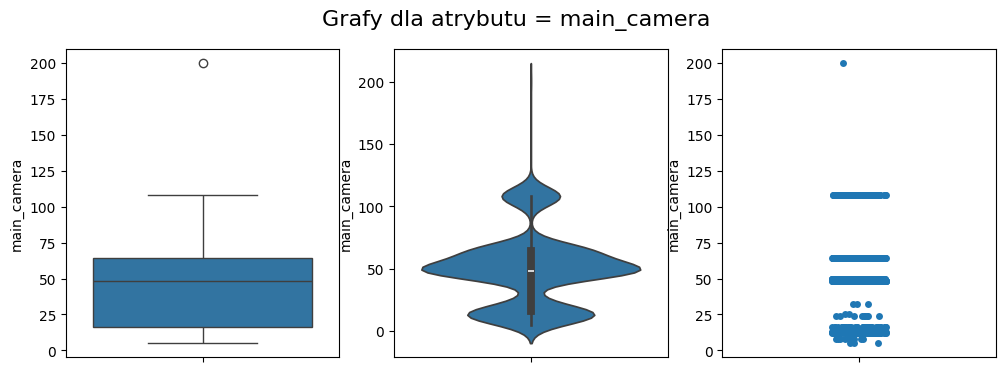

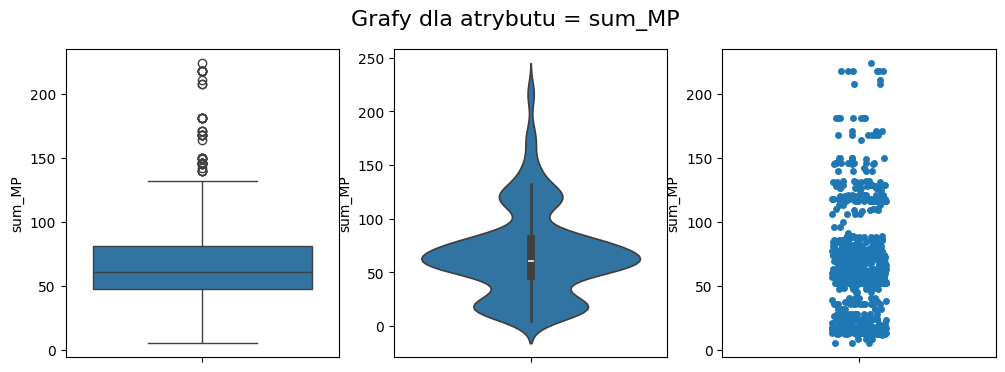

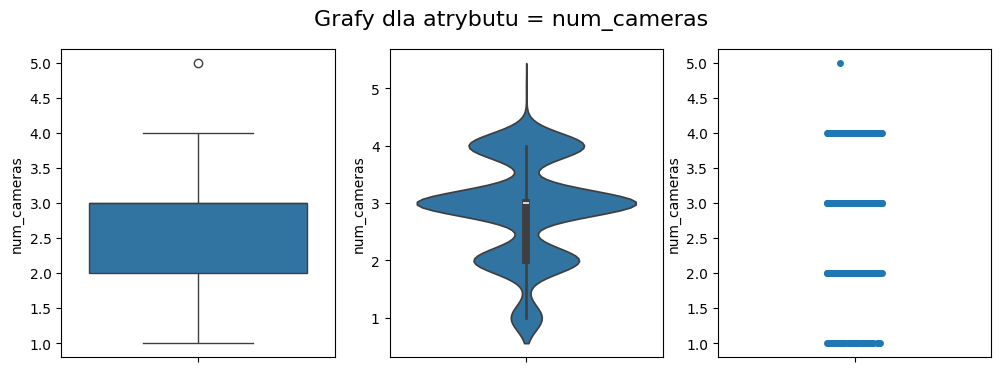

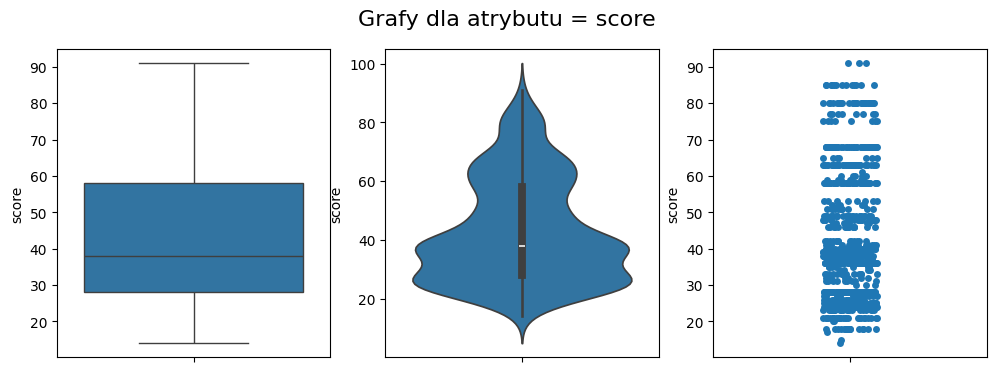

In [316]:
for attr in ['screen_size', 'battery_capacity', 'ram', 'internal_storage', 'price', 'front_camera', 'main_camera', 'sum_MP', 'num_cameras', 'score']:
    dane = df_android[attr]
    
    plt.figure(figsize=(12, 4))
    plt.suptitle(f'Grafy dla atrybutu = {attr}', fontsize=16)
    
    plt.subplot(1, 3, 1)
    plt.xticks(ha='right')
    sns.boxplot(data=dane)
    
    plt.subplot(1, 3, 2)
    plt.xticks(ha='right')
    sns.violinplot(data=dane)
    
    plt.subplot(1, 3, 3)
    plt.xticks(ha='right')
    sns.stripplot(data=dane)
    
    plt.show()

## Standardowe miary (Android)

In [317]:
android_description = df_android.describe()
android_description

,front_camera,battery_capacity,ram,internal_storage,price,score,num_cameras,sum_MP,main_camera,screen_size,refresh_rate
count,855.000000,855.000000,855.000000,855.000000,855.000000,855.000000,855.000000,855.000000,855.000000,855.000000,855.000000
mean,17.019883,4621.538012,6.883626,153.272515,75818.513450,43.008187,2.892398,67.442105,49.499415,6.500936,85.284211
std,8.808040,664.043794,2.793995,96.023560,54749.451452,17.735136,0.850747,40.480702,28.494581,0.322399,27.860852
min,2.000000,2600.000000,1.000000,8.000000,399.000000,14.000000,1.000000,5.000000,5.000000,5.000000,60.000000
25%,8.000000,4300.000000,4.000000,128.000000,37999.000000,28.000000,2.000000,47.000000,16.000000,6.430000,60.000000
50%,16.000000,4600.000000,8.000000,128.000000,59999.000000,38.000000,3.000000,61.000000,48.000000,6.530000,90.000000
75%,20.000000,5000.000000,8.000000,256.000000,88415.000000,58.000000,3.000000,81.000000,64.000000,6.670000,120.000000
max,44.000000,7000.000000,16.000000,512.000000,339999.000000,91.000000,5.000000,224.000000,200.000000,8.010000,144.000000


Współczynnik zmienności atrybutów

In [318]:
android_description.apply(calculate_coefficient_variation, axis = 0)

front_camera        0.517515
battery_capacity    0.143685
ram                 0.405890
internal_storage    0.626489
price               0.722112
score               0.412367
num_cameras         0.294132
sum_MP              0.600229
main_camera         0.575655
screen_size         0.049593
refresh_rate        0.326682
dtype: float64

Macierz korelacji

<Axes: >

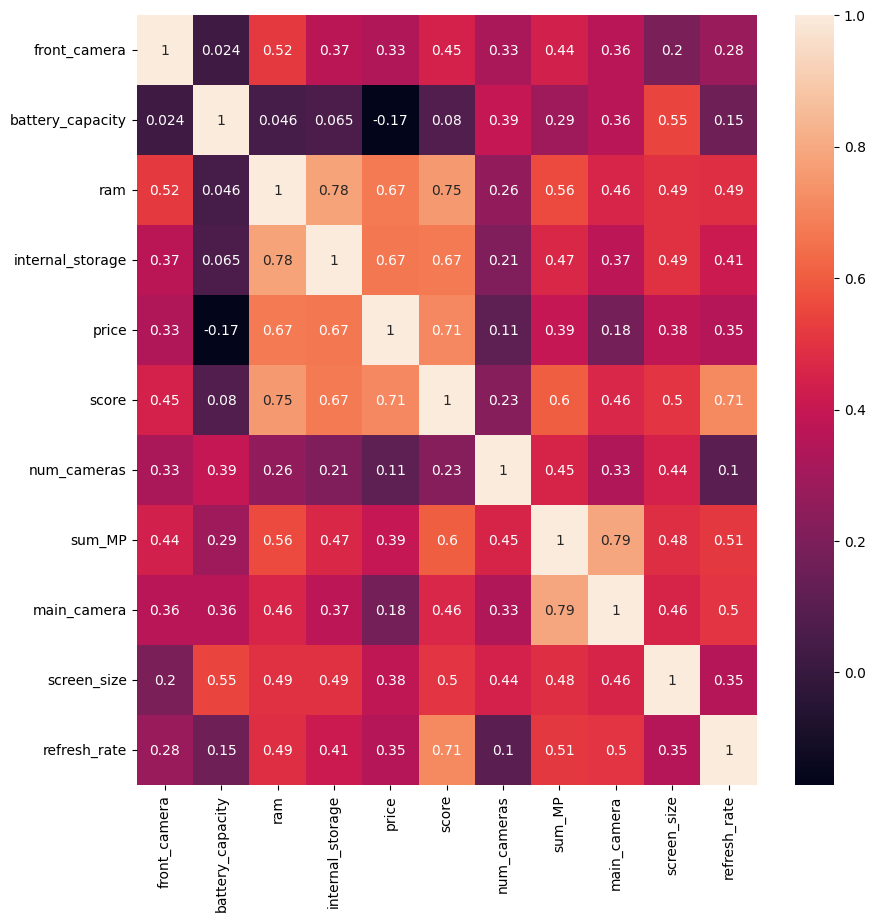

In [319]:
plt.figure(figsize=(10,10),dpi = 100)
sns.heatmap(df_android.iloc[:, [2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]].corr(),annot = df_android.iloc[:, [2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]].corr())

Atrybutami, które mają >= 60 korelację z ceną, są: ram, internal_storage, score. Z tych powyższych możemy użyć atrybutu score i internal_storage, bez atrybutu ram, ze względu na ich mocną korelację z atrybutem ram (0.75 i 0.78).

Pozostałe atrybuty są słabo skorelowane z ceną, przy czym atrybut num_cameras ma bardzo niską korelacje 0.11, przez co nie powinien praktycznie wpływać na rezultat. Najbardziej w zbiorze danych są ze sobą ponownie skorelowane są atrybuty sum_MP i main_camera. 

Dla smartfonów Apple

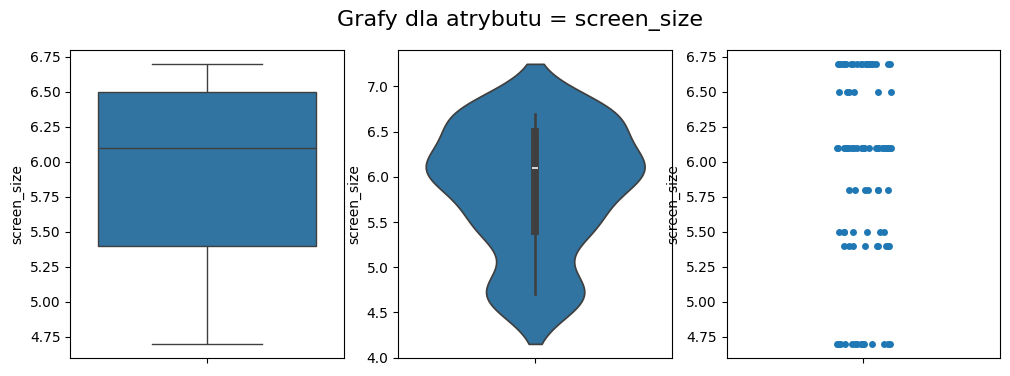

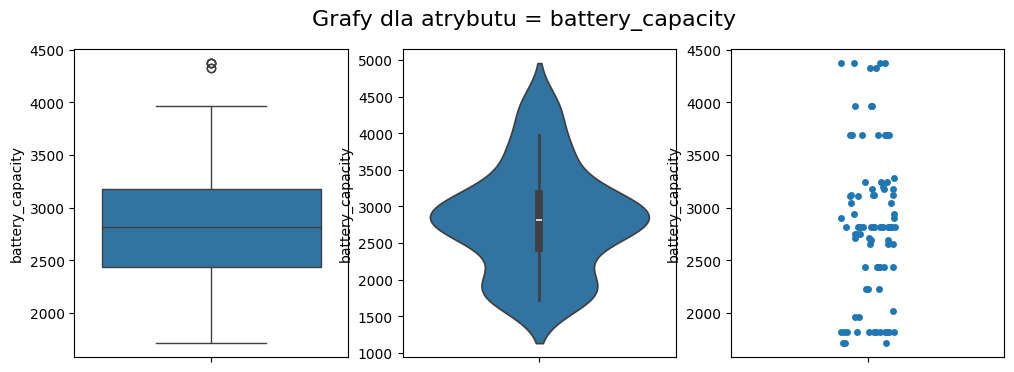

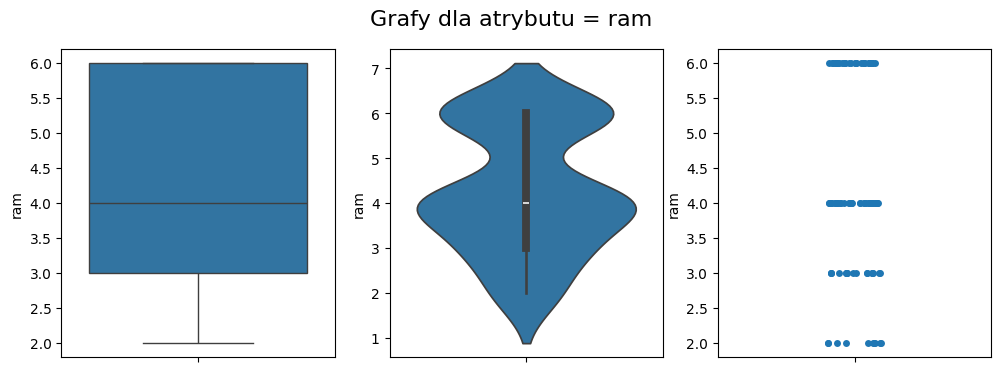

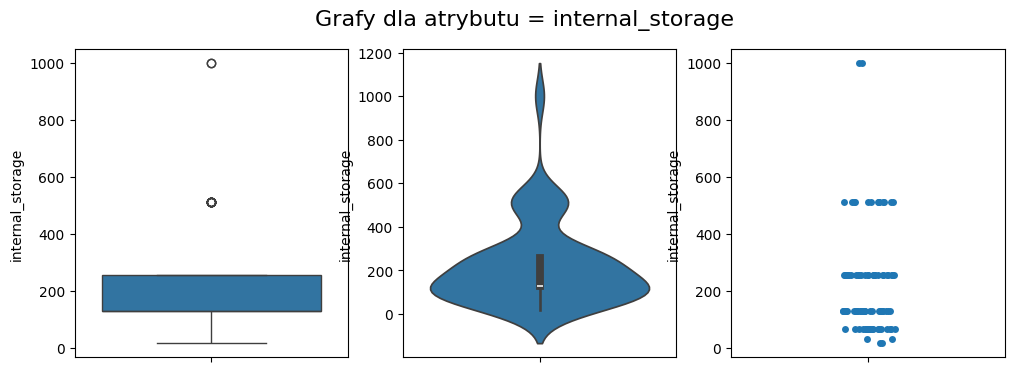

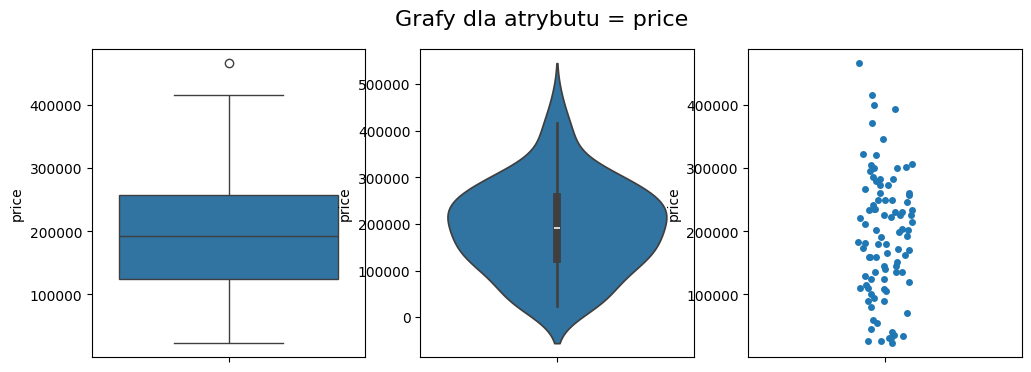

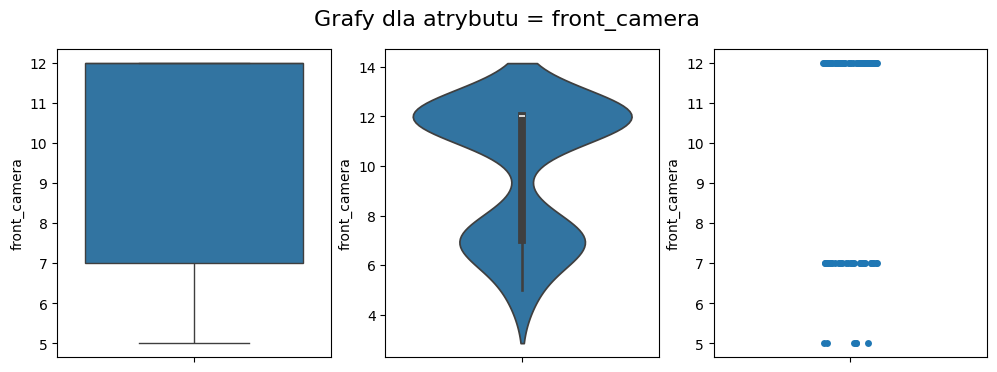

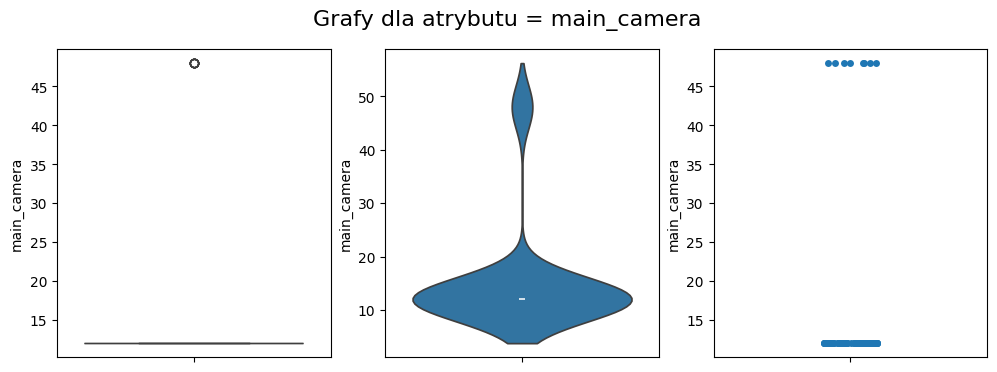

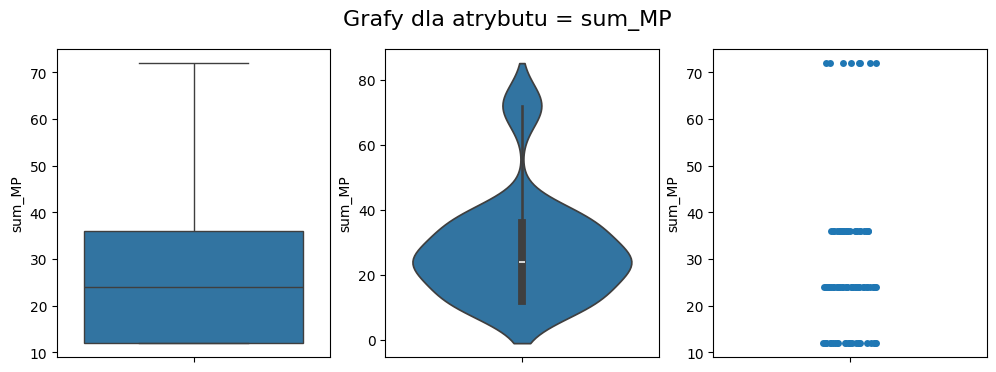

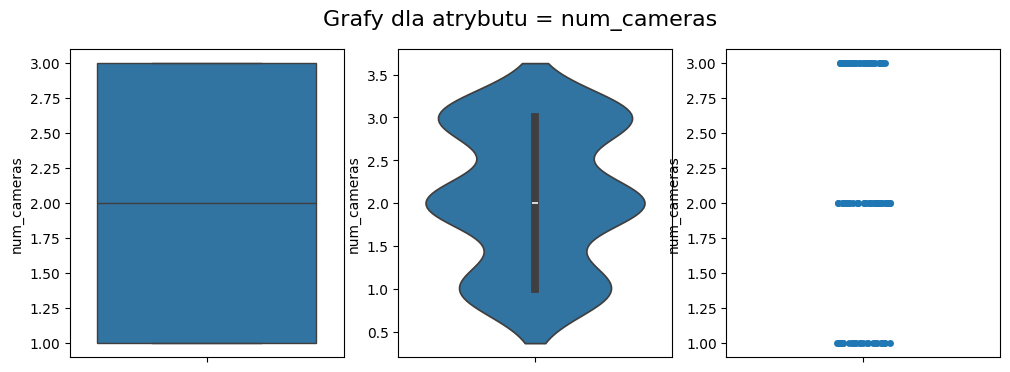

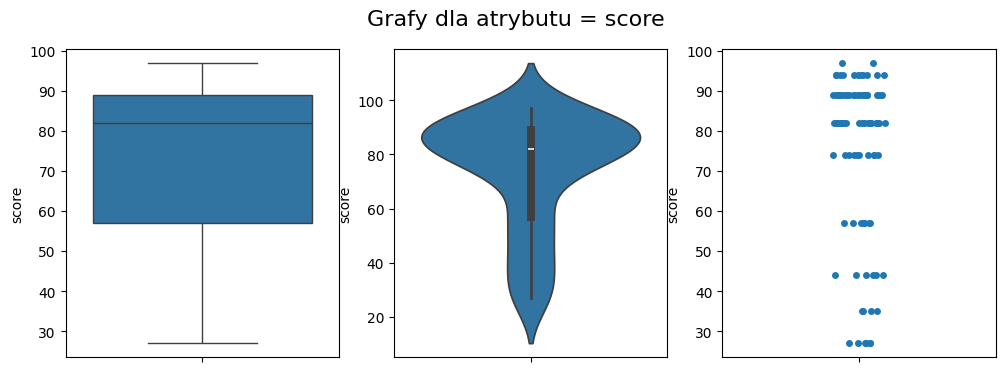

In [320]:
for attr in ['screen_size', 'battery_capacity', 'ram', 'internal_storage', 'price', 'front_camera', 'main_camera', 'sum_MP', 'num_cameras', 'score']:
    dane = df_apple[attr]
    
    plt.figure(figsize=(12, 4))
    plt.suptitle(f'Grafy dla atrybutu = {attr}', fontsize=16)
    
    plt.subplot(1, 3, 1)
    plt.xticks(ha='right')
    sns.boxplot(data=dane)
    
    plt.subplot(1, 3, 2)
    plt.xticks(ha='right')
    sns.violinplot(data=dane)
    
    plt.subplot(1, 3, 3)
    plt.xticks(ha='right')
    sns.stripplot(data=dane)
    
    plt.show()

## Standardowe miary (Apple)

In [321]:
apple_description = df_apple.describe()
apple_description

,front_camera,battery_capacity,ram,internal_storage,price,score,num_cameras,sum_MP,main_camera,screen_size,refresh_rate
count,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000
mean,9.881720,2822.978495,4.268817,218.666667,193012.182796,74.516129,2.075269,28.000000,15.096774,5.878495,70.322581
std,2.661519,721.717065,1.376351,187.098052,97531.276938,20.665879,0.783478,16.151457,10.148961,0.679810,22.767808
min,5.000000,1715.000000,2.000000,16.000000,22999.000000,27.000000,1.000000,12.000000,12.000000,4.700000,60.000000
25%,7.000000,2438.000000,3.000000,128.000000,124999.000000,57.000000,1.000000,12.000000,12.000000,5.400000,60.000000
50%,12.000000,2815.000000,4.000000,128.000000,192000.000000,82.000000,2.000000,24.000000,12.000000,6.100000,60.000000
75%,12.000000,3174.000000,6.000000,256.000000,256999.000000,89.000000,3.000000,36.000000,12.000000,6.500000,60.000000
max,12.000000,4373.000000,6.000000,1000.000000,465999.000000,97.000000,3.000000,72.000000,48.000000,6.700000,120.000000


Współczynnik zmienności atrybutów

In [322]:
apple_description.apply(calculate_coefficient_variation, axis = 0)

front_camera        0.269338
battery_capacity    0.255658
ram                 0.322420
internal_storage    0.855631
price               0.505312
score               0.277334
num_cameras         0.377531
sum_MP              0.576838
main_camera         0.672260
screen_size         0.115643
refresh_rate        0.323762
dtype: float64

<Axes: >

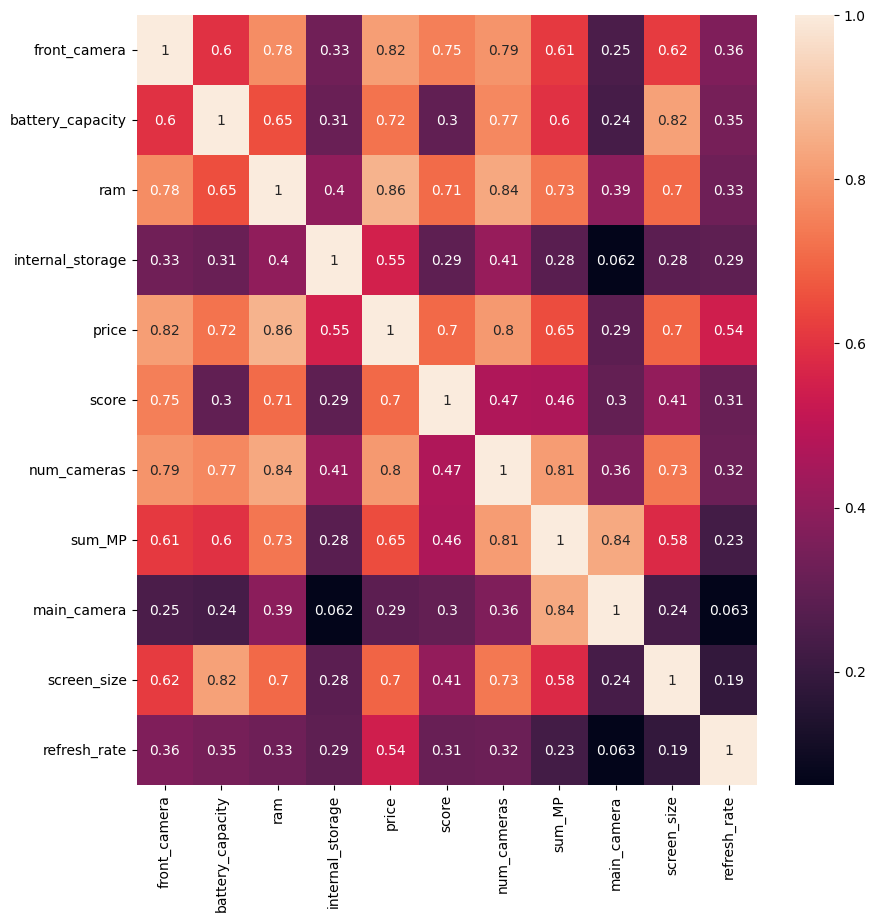

In [323]:
plt.figure(figsize=(10,10),dpi = 100)
sns.heatmap(df_apple.iloc[:, [2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]].corr(),annot = df_apple.iloc[:, [2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]].corr())

W powyższej macierzy, korelację >= 0.6 z ceną, mają atrybutu: front_camera, battery_capacity, ram, score, num_cameras, sum_MP, screen_size. Ze wględu na mocną korelację niektórych z tych atrybutów z ram można w modelu regresji użyć atrybutów ram, battery_capacity, front_camera.

## Użycie regresji liniowej

In [341]:
def use_regression(df, attributes, dec_attribute, test_size, random = 0, min_max = False, standarization = False, stratify_arg = ""):
    ''' 
    parametry:
        df - ramka danych, która zostanie podzielona na dane uczące i testowe,
        dec_attribute - atrybut decyzujący,
        test_size - rozmiar zbioru testowego, liczba w przedziale (0.0, 1.0>,
        random - wartość seed random_state w funkcji train_test_split,
        max_min - jeżeli True dokonuje normalizacji min_max danych,
        standarization - jeżeli True dokonuje standaryzacji danych
        *uwaga jeżeli param

    zwraca:
        e_train - błąd uczenia,
        e_test - błąd generalizacji
    '''
    df_t = df.loc[:, attributes]

    if min_max == True and standarization == True:
        raise ValueError('Podano wartość min_max == True i standarization == True')

    if min_max == True:
        print('Wykonuję normalizację')
        scaler = MinMaxScaler()
        df_t = scaler.fit_transform(df_t)
    
    if standarization == True:
        print('Wykonuję standaryzację')
        scaler = StandardScaler()
        df_t = scaler.fit_transform(df_t)

    if stratify_arg == "":
        x_train, x_test, y_train, y_test = train_test_split(df_t, df[dec_attribute], test_size = test_size, random_state = random)
    else:
        x_train, x_test, y_train, y_test = train_test_split(df_t, df[dec_attribute], test_size = test_size, random_state = random, stratify = df[stratify_arg])

    model = LinearRegression()
    model.fit(x_train, y_train)
    y_pred_train = model.predict(x_train)
    e_train = metrics.mean_squared_error(y_train, y_pred_train)
    y_pred_test = model.predict(x_test)
    e_test = metrics.mean_squared_error(y_test, y_pred_test)
    
    return e_train, e_test

In [342]:
def plot_results(x, dokl_ucz, dokl_test, title, x_label):
    '''
    funkcja odpowiada za wizualizacje dokladnosci uczenia dla danych testowych i uczących
    
    parametry:
        x - dana rozdzielczość, dla której zebrane są dane uczenia
        dokl_ucz - wyniki dokladnosci, dla danych uczących
        dokl_test - wyniki dokladnosci, dla danych testowych
    '''
    plt.figure(dpi=100)
    plt.title(title)
    plt.plot(x, dokl_ucz, 'bo-', label = 'dane uczące')
    plt.xlabel(x_label)
    plt.ylabel('Błąd')
    plt.plot(x, dokl_test, 'ro-', label = 'dane testowe')
    plt.legend(loc='center right')
    plt.show()

Funkcja klasyfikująca do grup, w zależności od ceny. Jest ona wymagana przy użyciu stratify w funkcji train_test_split, aby podzielić dane testowe i treningowe w równych proporcjach co do ich wartości

In [343]:
def classify_based_on_price(row, bins):
    for i in range(len(bins)):
        if (row['price'] >= bins[i]):
            return i
    return -1                                # returns where there is an error

Wszystkie atrybuty numeryczne:

In [344]:
all_attributes = ['front_camera', 'battery_capacity', 'ram', 'internal_storage', 'score', 'num_cameras', 'sum_MP', 'main_camera', 'screen_size', 'refresh_rate']

### Dla całości

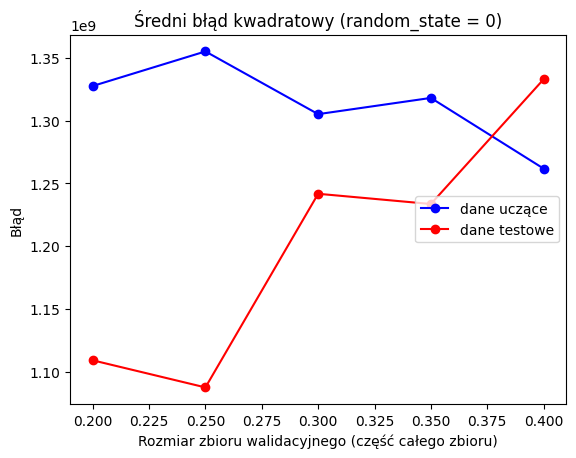

Minimalny błąd dla zbioru testowego = 1087407737.0379057 dla rozmiaru danych testowych = 0.25


In [370]:
error_train = []
error_test = []
test_size = [0.2, 0.25, 0.3, 0.35, 0.4]
for size in test_size:
    [e_train, e_test] = use_regression(df, all_attributes, 'price', size)
    error_train.append(e_train)
    error_test.append(e_test)

random = 0

title = 'Średni błąd kwadratowy (random_state = ' + str(random) + ')'
x_label = 'Rozmiar zbioru walidacyjnego (część całego zbioru)'
plot_results(test_size, error_train, error_test, title, x_label)
print('Minimalny błąd dla zbioru testowego =', min(error_test), 'dla rozmiaru danych testowych =', test_size[error_test.index(min(error_test))])

Proporcjonalny podział danych testowych i uczących

In [383]:
samples_per_bin, bins = np.histogram(df['price'], bins='doane')
bins = bins[:-5]   # aby pozbyć się jednoosobowej grupy
bins = bins[::-1]  # odwrócenie wartości w liście

df['classification'] = df.apply(classify_based_on_price, axis = 1, args = (bins,))

[e_train, e_test] = use_regression(df, all_attributes, 'price', 0.25, stratify_arg = 'classification')
print('Błąd uczenia:      ', e_train)
print('Błąd generalizacji:', e_test)

[115 311 161 160  54  34  35  27  16  11  15   4   1   2   1   1]
[3.99000e+02 2.94990e+04 5.85990e+04 8.76990e+04 1.16799e+05 1.45899e+05
 1.74999e+05 2.04099e+05 2.33199e+05 2.62299e+05 2.91399e+05 3.20499e+05
 3.49599e+05 3.78699e+05 4.07799e+05 4.36899e+05 4.65999e+05]
Błąd uczenia:       1278503606.547816
Błąd generalizacji: 1299598092.9440627


Nie poprawiło to rezultatów błędu generalizacji

Wybór parametru random

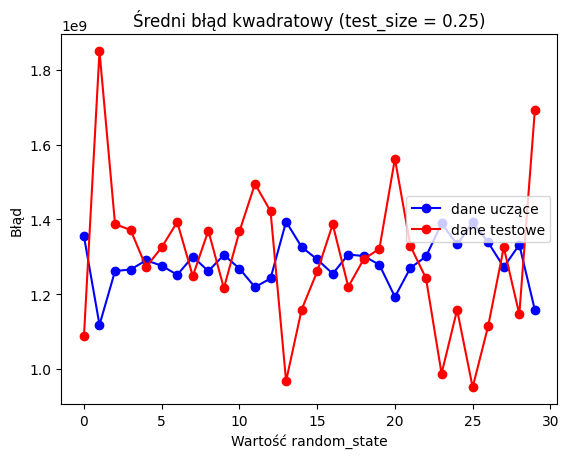

Minimalny błąd dla zbioru testowego = 951289660.7941284 dla wartości random_state = 25


In [371]:
r = range(30)
error_train = []
error_test = []
for random in range(30):
    [e_train, e_test] = use_regression(df, all_attributes, 'price', 0.25, random = random)
    error_train.append(e_train)
    error_test.append(e_test)

test_size = 0.25

title = 'Średni błąd kwadratowy (test_size = ' + str(test_size) + ')'
x_label = 'Wartość random_state'
plot_results(r, error_train, error_test, title, x_label)
print('Minimalny błąd dla zbioru testowego =', min(error_test), 'dla wartości random_state =', r[error_test.index(min(error_test))])

In [372]:
print('Normalizacja Min-Max')
[e_train_norm, e_test_norm] = use_regression(df, all_attributes, 'price', 0.25, random = 25, min_max = True)
print('Błąd uczenia      ', e_train_norm)
print('Błąd generalizacji', e_test_norm)
print()

print('Standaryzacja')
[e_train_stand, e_test_stand] = use_regression(df, all_attributes, 'price', 0.25, random = 25, standarization = True)
print('Błąd uczenia      ', e_train_stand)
print('Błąd generalizacji', e_test_stand)

Normalizacja Min-Max
Wykonuję normalizację
Błąd uczenia       1392261864.4654348
Błąd generalizacji 951289660.7941298

Standaryzacja
Wykonuję standaryzację
Błąd uczenia       1392261864.4654343
Błąd generalizacji 951289660.7941277


Zarówno normalizacja Min-Max, jak i standaryzacja nie dają lepszych rezultatów.

### Apple

Wybranie parametru test_size, do jak najlepszego podziału zbioru

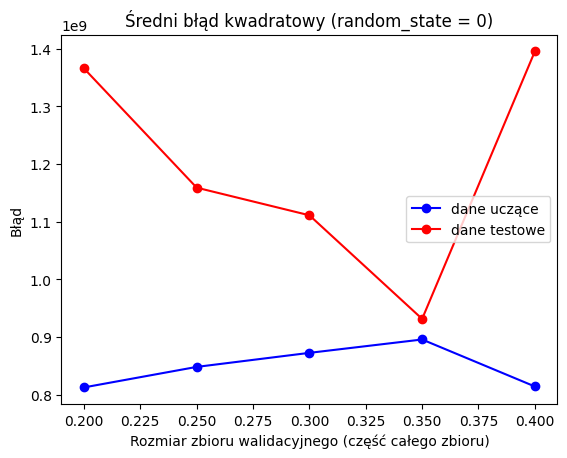

Minimalny błąd dla zbioru testowego = 931328889.7813454 dla rozmiaru danych testowych = 0.35


In [358]:
error_train = []
error_test = []
test_size = [0.2, 0.25, 0.3, 0.35, 0.4]
for size in test_size:
    [e_train, e_test] = use_regression(df_apple, all_attributes, 'price', size)
    error_train.append(e_train)
    error_test.append(e_test)

random = 0

title = 'Średni błąd kwadratowy (random_state = ' + str(random) + ')'
x_label = 'Rozmiar zbioru walidacyjnego (część całego zbioru)'
plot_results(test_size, error_train, error_test, title, x_label)
print('Minimalny błąd dla zbioru testowego =', min(error_test), 'dla rozmiaru danych testowych =', test_size[error_test.index(min(error_test))])

Proporcjonalny podział danych testowych i uczących

In [369]:
samples_per_bin, bins = np.histogram(df_apple['price'], bins='doane')
bins = bins[:-2]   # aby pozbyć się jednoosobowej grupy
bins = bins[::-1]  # odwrócenie wartości w liście

df_apple['classification'] = df_apple.apply(classify_based_on_price, axis = 1, args = (bins,))

[e_train, e_test] = use_regression(df_apple, all_attributes, 'price', 0.35, stratify_arg = 'classification')
print('Błąd uczenia:      ', e_train)
print('Błąd generalizacji:', e_test)

Błąd uczenia:       734259069.6664395
Błąd generalizacji: 1158926251.353681


In [ ]:
Proporcjonalny podział danych nie poprawił wyniku

Wybranie parametru random

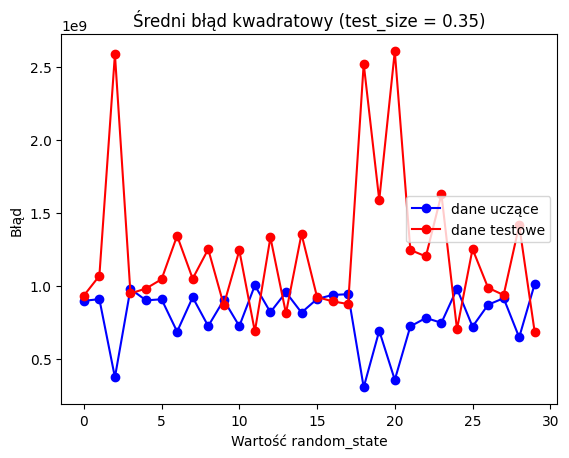

Minimalny błąd dla zbioru testowego = 679554313.0073652 dla wartości random_state = 29


In [365]:
r = range(30)
error_train = []
error_test = []
for random in range(30):
    [e_train, e_test] = use_regression(df_apple, all_attributes, 'price', 0.35, random = random)
    error_train.append(e_train)
    error_test.append(e_test)

test_size = 0.35

title = 'Średni błąd kwadratowy (test_size = ' + str(test_size) + ')'
x_label = 'Wartość random_state'
plot_results(r, error_train, error_test, title, x_label)
print('Minimalny błąd dla zbioru testowego =', min(error_test), 'dla wartości random_state =', r[error_test.index(min(error_test))])

In [367]:
print('Normalizacja Min-Max')
[e_train_apple_norm, e_test_apple_norm] = use_regression(df_apple, all_attributes, 'price', 0.35, random = 29, min_max = True)
print('Błąd uczenia      ', e_train_apple_norm)
print('Błąd generalizacji', e_test_apple_norm)
print()

print('Standaryzacja')
[e_train_apple_stand, e_test_apple_stand] = use_regression(df_apple, all_attributes, 'price', 0.35, random = 29, standarization = True)
print('Błąd uczenia      ', e_train_apple_stand)
print('Błąd generalizacji', e_test_apple_stand)

Normalizacja Min-Max
Wykonuję normalizację
Błąd uczenia       1012249957.3578495
Błąd generalizacji 679554313.0073775

Standaryzacja
Wykonuję standaryzację
Błąd uczenia       1012249957.3578496
Błąd generalizacji 679554313.0073763


Zarówno normalizacja Min-Max, jak i standaryzacja nie dały lepszych rezultatów.

### Dla Android

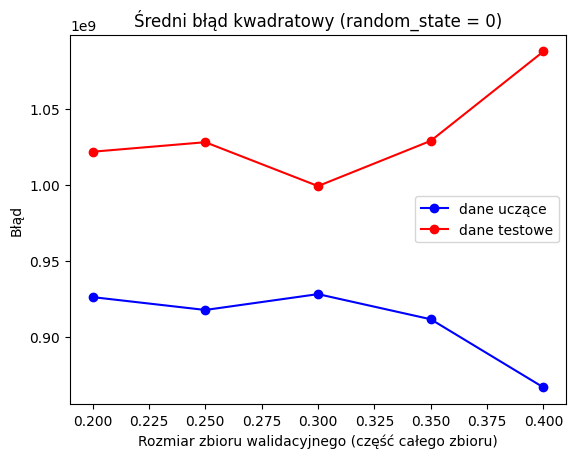

Minimalny błąd dla zbioru testowego = 999398471.9764955 dla rozmiaru danych testowych = 0.3


In [351]:
error_train = []
error_test = []
test_size = [0.2, 0.25, 0.3, 0.35, 0.4]
for size in test_size:
    [e_train, e_test] = use_regression(df_android, all_attributes, 'price', size)
    error_train.append(e_train)
    error_test.append(e_test)

random = 0

title = 'Średni błąd kwadratowy (random_state = ' + str(random) + ')'
x_label = 'Rozmiar zbioru walidacyjnego (część całego zbioru)'
plot_results(test_size, error_train, error_test, title, x_label)
print('Minimalny błąd dla zbioru testowego =', min(error_test), 'dla rozmiaru danych testowych =', test_size[error_test.index(min(error_test))])

Dokonanie proporcjonalnego podziału zbioru danych uczących i testowych

In [352]:
samples_per_bin, bins = np.histogram(df_android['price'], bins='doane')
bins = bins[:-1]   # aby pozbyć się jednoosobowej grupy
bins = bins[::-1]  # odwrócenie wartości w liście

df_android['classification'] = df_android.apply(classify_based_on_price, axis = 1, args = (bins,))

[e_train, e_test] = use_regression(df_android, all_attributes, 'price', 0.3, stratify_arg = 'classification')
print(e_train)
print(e_test)

917962290.7622564
1008659213.6378255


Dzięki proporcjonalnemu podziałowi błąd generalizacji praktycznie się nie zmienił, zwiększając delikatnie swoją wartość

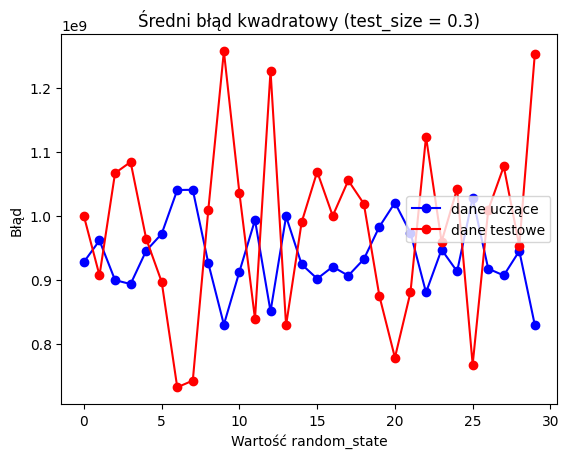

Minimalny błąd dla zbioru testowego = 732697405.4611201 dla wartości random_state = 6


In [353]:
r = range(30)
error_train = []
error_test = []
test_size = 0.3
for random in r:
    [e_train, e_test] = use_regression(df_android, all_attributes, 'price', test_size, random = random)
    error_train.append(e_train)
    error_test.append(e_test)

title = 'Średni błąd kwadratowy (test_size = ' + str(test_size) + ')'
x_label = 'Wartość random_state'
plot_results(r, error_train, error_test, title, x_label)
print('Minimalny błąd dla zbioru testowego =', min(error_test), 'dla wartości random_state =', r[error_test.index(min(error_test))])

Jednak dzięki wykorzystaniu innej wartości random_state przy podziale udało się jeszcze bardziej zmniejszyć wartość błędu.

Sprawdzenie zmiany względem normalizacji min-max i standaryzacji danych:

In [354]:
print('Normalizacja Min-Max')
[e_train_android_norm, e_test_android_norm] = use_regression(df_android, all_attributes, 'price', 0.3, random = 6, min_max = True)
print('Błąd uczenia      ', e_train_android_norm)
print('Błąd generalizacji', e_test_android_norm)
print()

print('Standaryzacja')
[e_train_android_stand, e_test_android_stand] = use_regression(df_android, all_attributes, 'price', 0.3, random = 6, standarization = True)
print('Błąd uczenia      ', e_train_android_stand)
print('Błąd generalizacji', e_test_android_stand)

Normalizacja Min-Max
Wykonuję normalizację
Błąd uczenia       1040352959.4738796
Błąd generalizacji 732697405.4611228

Standaryzacja
Wykonuję standaryzację
Błąd uczenia       1040352959.4738796
Błąd generalizacji 732697405.4611231


Zarówno normalizacja Min-Max, jak i standaryzacja danych nie dały lepszych rezultatów

### Przeliczenie w celu porównania rozdzielenia zbioru danych

In [399]:
test_error         = 951289660.7941284
apple_test_error   = 679554313.0073652
android_test_error = 732697405.4611201

n_apple = len(df_apple)
n_android = len(df_android)
test_error_splitted = (n_apple*apple_test_error + n_android*android_test_error)/(n_apple + n_android)
print('Całkowity błąd pezy rozdzieleniu danych', test_error_splitted)
print('Jest on o', 1 - test_error_splitted/test_error, '% mniejszy od błędu przed rozdzieleniem danych')

Całkowity błąd pezy rozdzieleniu danych 727484000.8216695
Jest on o 0.23526552342178086 % mniejszy od błędu przed rozdzieleniem danych


Jak można zauważyć rozdzielenie danych na 2 zbiory, w zależnosci od systemu operacyjnego było dobrym rozwiązaniem